In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("yearly_clean.tsv", sep="\t")
df["year"] = df["year"].astype(int)

year_totals = df.groupby("year")["count"].sum().rename("total_year_count")
df = df.merge(year_totals, on="year")
df["popularity"] = df["count"] / df["total_year_count"]


In [2]:
from typing import List, Dict

# AI 1.0 – ML / Data / DL 生態
ai_core_tags = [
    "machine-learning", "deep-learning", "neural-network",
    "data-science", "nlp", "computer-vision",
]

ai_python_stack = [
    "tensorflow", "keras", "pytorch", "scikit-learn",
    "numpy", "pandas",
]

# AI 2.0 – LLM / ChatGPT / OpenAI 生態
ai_llm_tags = [
    "chatgpt", "gpt", "gpt-3", "gpt-4",
    "openai-api", "llm", "langchain",
    "huggingface-transformers",
]

def existing_tags(df: pd.DataFrame, tags: List[str]) -> List[str]:
    tag_set = set(df["tag"].unique())
    found = [t for t in tags if t in tag_set]
    missing = [t for t in tags if t not in tag_set]
    print("Found:", found)
    print("Missing:", missing)
    return found

print("AI core:")
_ = existing_tags(df, ai_core_tags)
print("\nAI Python stack:")
_ = existing_tags(df, ai_python_stack)
print("\nLLM tags:")
_ = existing_tags(df, ai_llm_tags)


AI core:
Found: ['machine-learning', 'deep-learning', 'neural-network', 'data-science', 'nlp', 'computer-vision']
Missing: []

AI Python stack:
Found: ['tensorflow', 'keras', 'pytorch', 'scikit-learn', 'numpy', 'pandas']
Missing: []

LLM tags:
Found: ['gpt-3', 'gpt-4', 'openai-api', 'langchain', 'huggingface-transformers']
Missing: ['chatgpt', 'gpt', 'llm']


Found: ['machine-learning', 'deep-learning', 'neural-network', 'data-science', 'nlp', 'computer-vision', 'tensorflow', 'keras', 'pytorch', 'scikit-learn', 'numpy', 'pandas', 'gpt-3', 'gpt-4', 'openai-api', 'langchain', 'huggingface-transformers']
Missing: ['chatgpt', 'gpt', 'llm']


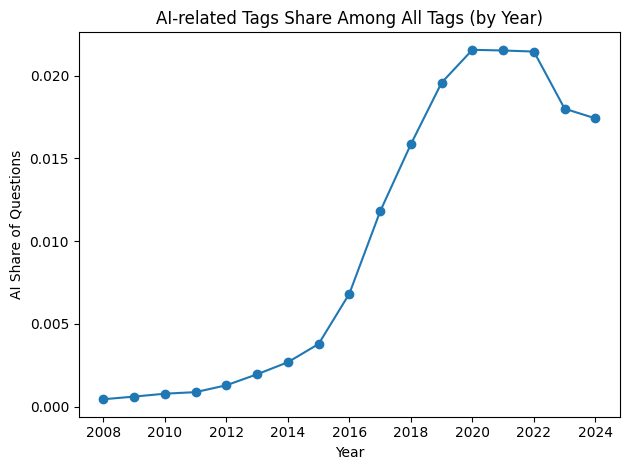

,non_ai_count,ai_count,total,ai_share
year,,,,
2020,5445178,120000,5565178,0.021563
2021,4481901,98575,4580476,0.021521
2022,3930903,86193,4017096,0.021457
2023,2813868,51587,2865455,0.018003
2024,525675,9319,534994,0.017419


In [3]:
# 用現在能找到的 AI / LLM tags 組合成一個 AI 大集合
ai_all_tags = set(existing_tags(df, ai_core_tags + ai_python_stack + ai_llm_tags))

# 計算每年 AI vs non-AI 的 count 和 share
year_ai = df.assign(
    is_ai=df["tag"].isin(ai_all_tags)
).groupby(["year", "is_ai"])["count"].sum().reset_index()

ai_pivot = year_ai.pivot(index="year", columns="is_ai", values="count").fillna(0)
ai_pivot.columns = ["non_ai_count", "ai_count"] if False in ai_pivot.columns else ["ai_count", "non_ai_count"]
ai_pivot["total"] = ai_pivot["ai_count"] + ai_pivot["non_ai_count"]
ai_pivot["ai_share"] = ai_pivot["ai_count"] / ai_pivot["total"]

ax = ai_pivot["ai_share"].plot(marker="o")
ax.set_title("AI-related Tags Share Among All Tags (by Year)")
ax.set_xlabel("Year")
ax.set_ylabel("AI Share of Questions")
plt.tight_layout()
plt.show()

ai_pivot.tail()


Found: ['tensorflow', 'keras', 'pytorch', 'scikit-learn']
Missing: []


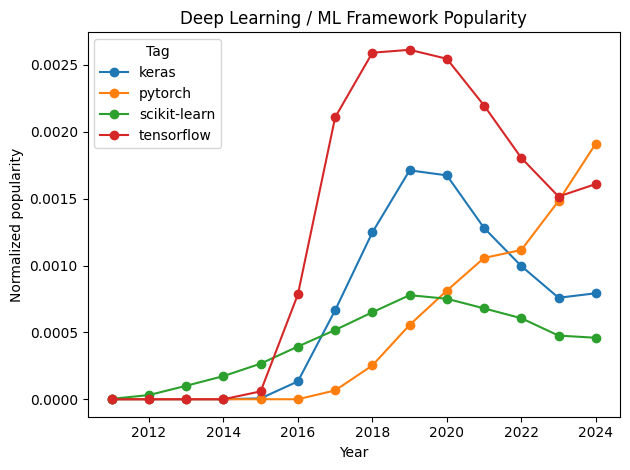

In [4]:
def plot_tag_trends(data: pd.DataFrame, tags: List[str], title: str):
    subset = data[data["tag"].isin(tags)].copy()
    if subset.empty:
        print("No data for tags:", tags)
        return
    pivot = subset.pivot(index="year", columns="tag", values="popularity").fillna(0)
    ax = pivot.plot(marker="o")
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Normalized popularity")
    ax.legend(title="Tag")
    plt.tight_layout()
    plt.show()

ml_framework_tags = existing_tags(df, ["tensorflow", "keras", "pytorch", "scikit-learn"])

plot_tag_trends(
    df,
    ml_framework_tags,
    title="Deep Learning / ML Framework Popularity"
)


In [5]:
def summarize_tags(data: pd.DataFrame, tags: List[str]) -> pd.DataFrame:
    records = []
    for t in tags:
        sub = data[data["tag"] == t].sort_values("year")
        if sub.empty:
            continue
        first_year = sub["year"].iloc[0]
        last_year = sub["year"].iloc[-1]
        pop_first = sub["popularity"].iloc[0]
        pop_last = sub["popularity"].iloc[-1]
        change = pop_last - pop_first
        rel_change = (change / pop_first * 100) if pop_first > 0 else None
        peak_idx = sub["popularity"].idxmax()
        peak_year = int(sub.loc[peak_idx, "year"])
        peak_pop = float(sub.loc[peak_idx, "popularity"])
        records.append({
            "tag": t,
            "first_year": int(first_year),
            "last_year": int(last_year),
            "popularity_first": pop_first,
            "popularity_last": pop_last,
            "absolute_change": change,
            "relative_change_%": rel_change,
            "peak_year": peak_year,
            "peak_popularity": peak_pop,
        })
    return pd.DataFrame(records).sort_values("absolute_change", ascending=False)

summary_ml = summarize_tags(df, ml_framework_tags)
summary_ml


,tag,first_year,last_year,popularity_first,popularity_last,absolute_change,relative_change_%,peak_year,peak_popularity
2,pytorch,2017,2024,0.000066,0.001912,0.001846,2798.664182,2024,0.001912
0,tensorflow,2015,2024,0.000059,0.001609,0.001551,2634.896040,2019,0.002613
1,keras,2015,2024,0.000007,0.000793,0.000786,11864.606915,2019,0.001712
3,scikit-learn,2011,2024,0.000003,0.000460,0.000457,15490.592680,2019,0.000778


Found: ['tensorflow', 'pytorch']
Missing: []


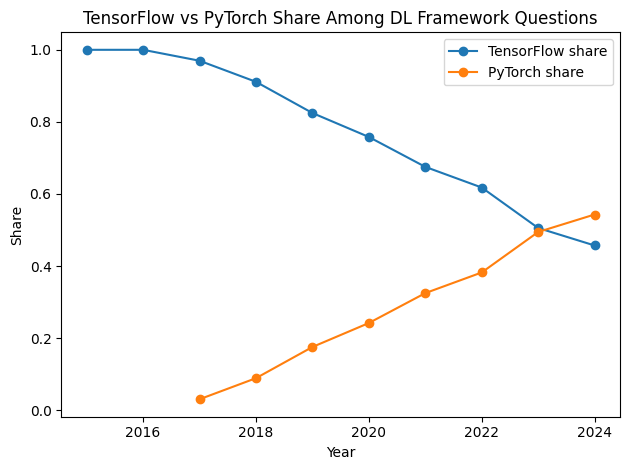

In [6]:
def compute_ratio(data: pd.DataFrame, numerator_tags, denominator_tags, name: str):
    num = data[data["tag"].isin(numerator_tags)].groupby("year")["count"].sum()
    den = data[data["tag"].isin(denominator_tags)].groupby("year")["count"].sum()
    ratio = (num / den).rename(name)
    return ratio.reset_index()

tf_pt_tags = existing_tags(df, ["tensorflow", "pytorch"])

if len(tf_pt_tags) >= 2:
    ratio_tf = compute_ratio(
        df,
        numerator_tags=["tensorflow"],
        denominator_tags=["tensorflow", "pytorch"],
        name="tf_share"
    )
    ratio_pt = compute_ratio(
        df,
        numerator_tags=["pytorch"],
        denominator_tags=["tensorflow", "pytorch"],
        name="pt_share"
    )

    ax = ratio_tf.set_index("year")["tf_share"].plot(marker="o", label="TensorFlow share")
    ratio_pt.set_index("year")["pt_share"].plot(marker="o", label="PyTorch share")
    ax.set_title("TensorFlow vs PyTorch Share Among DL Framework Questions")
    ax.set_xlabel("Year")
    ax.set_ylabel("Share")
    ax.legend()
    plt.tight_layout()
    plt.show()

    ratio_pt.tail()
else:
    print("Not enough data for both TensorFlow and PyTorch.")


In [7]:
python_related = existing_tags(df, ["python"] + ai_python_stack)

# 取出這些 tag 的 yearly popularity
sub = df[df["tag"].isin(python_related)]
pivot = sub.pivot(index="year", columns="tag", values="popularity").fillna(0)

# 計算與 python popularity 的 Pearson correlation
corr_with_python = pivot.corr()["python"].sort_values(ascending=False)
corr_with_python


Found: ['python', 'tensorflow', 'keras', 'pytorch', 'scikit-learn', 'numpy', 'pandas']
Missing: []


tag
python          1.000000
pandas          0.982648
numpy           0.959132
scikit-learn    0.916675
keras           0.891740
tensorflow      0.882588
pytorch         0.819183
Name: python, dtype: float64

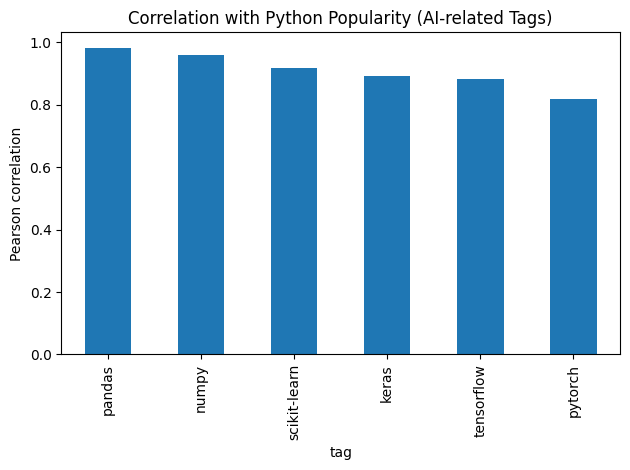

In [8]:
ax = corr_with_python.drop("python").plot(kind="bar")
ax.set_title("Correlation with Python Popularity (AI-related Tags)")
ax.set_ylabel("Pearson correlation")
plt.tight_layout()
plt.show()


Found: ['gpt-3', 'gpt-4', 'openai-api', 'langchain', 'huggingface-transformers']
Missing: ['chatgpt', 'gpt', 'llm']


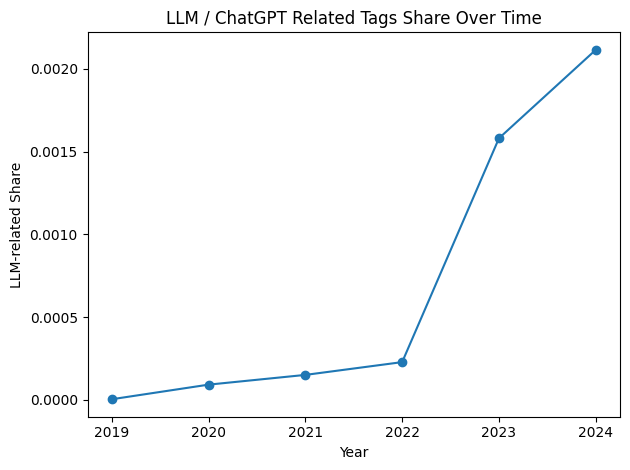

In [9]:
llm_existing = existing_tags(df, ai_llm_tags)

if llm_existing:
    llm_sub = df[df["tag"].isin(llm_existing)]
    llm_yearly = llm_sub.groupby("year")["count"].sum().rename("llm_count").reset_index()

    # 也算一下 normalized share
    total_year = df.groupby("year")["count"].sum().rename("total_count").reset_index()
    llm_yearly = llm_yearly.merge(total_year, on="year", how="left")
    llm_yearly["llm_share"] = llm_yearly["llm_count"] / llm_yearly["total_count"]

    ax = llm_yearly.plot(x="year", y="llm_share", marker="o", legend=False)
    ax.set_title("LLM / ChatGPT Related Tags Share Over Time")
    ax.set_xlabel("Year")
    ax.set_ylabel("LLM-related Share")
    plt.tight_layout()
    plt.show()

    llm_yearly.tail()
else:
    print("No LLM-related tags found in current dataset.")
